# Automatic Speech Recognition with Transformer
**Description:** Huyến luyện một mô hình sequence-to-sequence Transformer cho automatic speech recognition (ASR).

## Giới thiệu

Automatic speech recognition (ASR) bao gồm việc chuyển các đoạn âm thanh giọng nói thành văn bản.
ASR có thể được coi là một vấn đề nghiên cứu của sequence-to-sequence, trong đó
âm thanh có thể được biểu diễn dưới dạng một chuỗi các vectơ đặc trưng
và văn bản dưới dạng một chuỗi ký tự, từ hoặc mã từ phụ.

Đối với phần hiên thực này, nhóm em sẽ sử dụng bộ dữ liệu tự cào bàng code trên trang https://learningenglish.voanews.com 
Nó bao gồm
đoạn âm thanh của một người nói đọc một đoạn văn. nhóm em sử dụng model để tách âm thanh và trích xuất văn bản tương ứng


In [1]:
# import các thư viện
import os
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


## Định nghĩa lớp Input của model Transformer

Khi xử lý target tokens trước đó cho decoder, nhóm em tính tổng các vị trí nhúng và token nhúng

Khi xử lý các đặc trưng của file audio thì nhóm em sử dụng mạng tích chập để giảm kích thước của sample mà vẫn giữ nguyên đặc trưng
thông qua sải bước (strides) và xử lý local relationships

In [2]:
# biểu diễn câu chữ dưới dạng vector
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        # khởi tạo một ma trận số nguyên với phần tử (word index) lớn nhất nhỏ hơn num_vocab
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        """
        input: x -> ma trận có số chiều cố định ví dụ array([[1,2,3,4,5,6], [4,5,6,3,2,1]]
        output: ma trận đã embedding tf.shape(len(x),len(x[0]), num_hid)
        """
        maxlen = tf.shape(x)[-1] # lấy độ dài của các phần tử bên trong ví dụ 6
        x = self.emb(x) # chuyển ma trận trên thành ma trận khác có shape là tf.shape(len(x),len(x[0]), num_hid)
        # đánh dấu vị trí của từ trong câu, vì một từ ở vị trí khác nhau của câu có thể sẽ mang ý nghĩa khác nhau
        positions = tf.range(start=0, limit=maxlen, delta=1) # tạo ma trận vị trí mối step là 1 ví dụ [0,1,2,3,4,5]
        positions = self.pos_emb(positions) # chuyển ma trận vị trí thành ma trận có shape(maxlen, num_hid)
        return x + positions # trả về tổng của giá trị của ma trận x sau khi nhúng và ma trận vị trí sau khi nhúng


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        # Từ vector input, tạo ra một convolution kernel được xoay vòng để tạo ra nhiều đầu ra
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )

    def call(self, x):
        """
            input: ma trận x lúc này là ma trận 3 chiều nên thường là ma trận đã được embedding ở trên ví dụ một ma trận có shape(8, 8, 64) được embed từ ma trận (8,8)
            output: là một mảng đã được downsample 3 lần, mỗi lớp ta sẽ chia dữ liệu ra còn một nữa
        """
        x = self.conv1(x) # (8, 4, 64)
        x = self.conv2(x) # (8, 2, 64)
        return self.conv3(x) # (8,1,64)


## Định nghĩa lớp Encoder của model Transformer

In [3]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        # sử dụng multi-head attention để tìm sự liên kết giữa các từ trong câu
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        # Thông tin ban đầu trước khi được self-attention (vector x) bổ sung thêm với 
        # thông tin đã được self-attention (vector z) - là mối quan hệ giữa các từ trong câu
        # sau đó mô hình thực hiện Layer Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        # Giai đoạn này được gọi là Residuals
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        """
        input: inputs -> Tensor shape=(None, seq_len, feed_forward_dim) ví dụ shape=(1, 345, 128)
            training -> False trong quá trình train
        output : shape=(1, 345, feed_forward_dim=128)
        """

        attn_output = self.att(inputs, inputs) # shape=(1, 345, 128)
        attn_output = self.dropout1(attn_output, training=training) # shape=(1, 345, 128)
        # chuẩn hóa inputs
        out1 = self.layernorm1(inputs + attn_output) # shape=(1, 345, 128)
        # Sau khi được Normalize, các vectors z được đưa qua mạng fully connected 
        # trước khi đẩy qua Decoder. Vì các vectors này không phụ thuộc vào nhau 
        # nên ta có thể tận dụng được tính toán song song cho cả câu.
        ffn_output = self.ffn(out1)  # feed-forward network shape=(1, 345, 128)
        ffn_output = self.dropout2(ffn_output, training=training) # shape=(1, 345, 128)
        return self.layernorm2(out1 + ffn_output) # shape=(1, 345, 128)


## Định nghĩa lớp Decoder của model Transformer

In [4]:
# Quá trình decode về cơ bản là giống với encode
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        # nếu ta sử dụng Multi-head attention trên cả câu như ở Encoder, 
        # Decoder sẽ nhận luôn từ tiếp theo mà nó cần dịch. Để ngăn điều đó, 
        # khi Decoder dịch đến từ thứ i, phần sau của câu sẽ bị che lại (masked) 
        # và Decoder chỉ được phép nhận thấy phần nó đã dịch trước đó.
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        # trả về mảng mới với các chiều dữ liệu mới dựa theo mult
        return tf.tile(mask, mult)

    def call(self, enc_out, target): # thiết kế lớp cho decoder
        """
            input: emc_out ->
                target -> 
            output: 
        """
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        # layer 1
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))

        # layer 2
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)

        # layer 3 feed-forward network
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        # output decode
        return ffn_out_norm


## Hoàn thành model Transformer

Model của nhóm em lấy phổ của âm thanh làm đầu vào và dự đoán thành một chuỗi ký tự

Trong quá trình huấn luyện, nhóm em cung cấp cho decoder một chuỗi các target character ở bên trái như input

Trong suốt quá trình suy luận, decoder sử dụng quá khứ của chính nó để dự đoán cho các token tiếp theo

In [5]:

class Transformer(keras.Model):
    # truyền vào các tham số, các nút trong các tầng ẩn
    def __init__(
        self,
        num_hid=64,
        num_head=2, # chiều của các embedding
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10, # class
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        # Dự đoán từng từ trong câu
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        """
            input: đưa vào các ký tự
            output: nhãn của ký tự đó
        """
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        # Xử lý một batch trong model.fit()
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        """
            input: truyền vào batch của data
            output: trả về dict keylaf loss
        """
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        # Thực hiện suy luận trên một loạt đầu vào (batch of input) bằng cách sử dụng giải thuật greedy
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input


## Tiền xử lý dữ liệu

In [6]:
DATA_ROOT = 'dataset'
MAX_TARGET_LEN = 200  # tất cả các text có độ dài < 200 ký tự

folders = os.listdir(DATA_ROOT)
data = [] # tạo dict để lưu đường dẫn và nội dung file
for s in folders:
    audio = os.path.join(DATA_ROOT,s, 'audio.wav')
    text = s.lower()
    data.append({'audio':audio, 'text':text})

In [7]:
# VectorizeChar để chuyển các char trong text thành vector id ký tự
class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            [str(i) for i in range(10)]
            + ["<", ">", "-", "#", "/", " ", ".", ",", "?", "!"]
            + [chr(i + 96) for i in range(1, 27)]
            + ["đ","â", "ă", "ê", "ô", "ơ", "ư", "à", "ằ", "ầ", "è", "ề", "ò", "ồ", "ờ", "ù", "ừ", "ì", "ỳ", "á", "ắ", "ấ", "é", "ế", "ó", "ố", "ớ", "ú", "ứ", "í", "ý", "ả", "ẳ", "ẩ", "ẻ", "ể", "ỏ", "ổ", "ở", "ủ", "ử", "ỉ", "ỷ", "ã", "ẵ", "ẫ", "ẽ", "ễ", "õ", "ỗ", "ỡ", "ũ", "ữ", "ĩ", "ỹ", "ạ", "ặ", "ậ", "ẹ", "ệ", "ọ", "ộ", "ợ", "ụ", "ự", "ị", "ỵ"]
        )
        self.max_len = max_len
        # dữ liệu trong char_to_idx là: vocab: id
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

        self.vocab_size = len(self.vocab)

        
    def __call__(self, text):
        """
            input: text
            output: danh sách id của các ký tự (char)
        """
        # viết thường hết đoạn text truyền vào
        text = text.lower()
        # lấy kích thước các ký tự trong text không quá maxlen-2
        text = text[: self.max_len - 2]
        # đưa text vào trong ngoặc nhọn
        text = "<" + text + ">"
        # dùng để padding đoạn text
        pad_len = self.max_len - len(text)
        # nếu ký tự không có trong list thì mặc định là 13, sau khi bỏ đi phần sau của text thì chúng ta sẽ để padding
        return [self.char_to_idx.get(ch, 13) for ch in text] + [12] * pad_len

    def get_vocabulary(self):
        # output: danh sách vocab
        return self.vocab
    
    def decode(self, vector):
        text = ''
        for value in vector:
            text += self.vocab[value]
        return text

In [9]:
vectorizer = VectorizeChar(MAX_TARGET_LEN)
print("vocab size (numclass) is", len(vectorizer.get_vocabulary()))

vocab size (numclass) is 113


In [10]:
def create_text_ds(data):
    """
        input: data là một danh sách các dict có cấu trúc: 
                audio: đường dẫn đến file audio wav,
                text: chứa nội dung text (không quá maxlen)
        output: các vector của text trong data dưới dạng TensorSliceDataset 
    """
    # các text trong data
    texts = [_["text"] for _ in data]
    # chuyển thành vector các texts
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds

# có vấn đề dữ liệu nan
# bạn có thể giải quyết vấn đề này bằng cách thêm một giá trị nhỏ (0.000001) vào Std như thế này (stackoverflow )
def path_to_audio(path):
    """
        input: đường dẫn của file audio wav
        output: x là phổ của audio đã được chuẩn hóa có shape = (pad_len, ?)
    """
    # phân tích phổ của âm thanh bằng stft
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)
    # chuyển shape của audio sang 1d từ (?, 1) thành (?,)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)
    # lấy căn trị tuyệt đối của phổ
    x = tf.math.pow(tf.abs(stfts), 0.5)
    # chuẩn hóa theo trung bình và lộ lệch chuẩn của từng mảng phần tử trong x
    means = tf.math.reduce_mean(x, 1, keepdims=True)
    stddevs = tf.math.reduce_std(x, 1, keepdims=True) + 0.000001
    x = (x - means) / stddevs
    audio_len = tf.shape(x)[0]
    # padding 10 giây
    pad_len = 2754
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    return x 

def create_audio_ds(data):
    """
        input: data là một danh sách các dict có cấu trúc: 
                audio: đường dẫn đến file audio wav,
                text: chứa nội dung text (không quá maxlen)
        output: các phổ của audio đã được chuẩn hóa
    """
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        path_to_audio, num_parallel_calls=tf.data.AUTOTUNE
    )
    return audio_ds


def create_tf_dataset(data, bs=4):
    """
        input: 
            data: một danh sách các dict có cấu trúc: 
                audio: đường dẫn đến file audio wav,
                text: chứa nội dung text (không quá maxlen)
            bs là batch size
        output: là một PrefetchDataset như dict có cấu trúc: 
            source: chứa tất cả phổ của âm thanh đã được chuẩn hóa
            target: chứa tất cả vector của text
    """
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)

    # đùng để loại bỏ đi những mảng có nan bên trong
    #filter_nan = lambda x, y: not tf.reduce_any(tf.math.is_nan(tf.float64))
    # zip audio values và vector của text
    ds = tf.data.Dataset.zip((audio_ds, text_ds)) #.filter(filter_nan)
    # chuyển thành dict
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [11]:
sample = path_to_audio(data[100]['audio'])
sample

<tf.Tensor: shape=(2754, 129), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [12]:
# chia train valid test
# với train là 80%, test là 19% và nhóm em dành 1% cho valid
split_point= int(len(data) * 0.95)

train_data = data[:split_point]
test_data = data[split_point:]

train_ds = create_tf_dataset(train_data, bs=8)
val_ds = create_tf_dataset(train_data, bs=4)

In [13]:
print(train_ds)
len(train_ds)

<PrefetchDataset element_spec={'source': TensorSpec(shape=(None, None, 129), dtype=tf.float32, name=None), 'target': TensorSpec(shape=(None, 200), dtype=tf.int32, name=None)}>


29

## Định nghĩa một callbacks để hiển thị các dự đoán

In [14]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        # Hiển thị một batch kết quả đầu ra sau mỗi epoch

        # Các tham số:
        #     batch: Một batch thử nghiệm chứa các khóa "source" và "target"
        #     idx_to_token: Danh sách chứa các mã thông báo từ vựng tương ứng với các chỉ số của chúng
        #     target_start_token_idx: Chỉ mục mã thông báo bắt đầu trong từ vựng target
        #     target_end_token_idx: Chỉ mục mã thông báo kết thúc trong từ vựng target
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        # trong mỗi epoch nếu %5 != 0 thì không làm gì cả
        # hàm này sẽ in ra quá kết quả dự đoán và kết quả thực tế của model trong quá trình training
        if epoch % 5 != 0:
            return
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        print()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")


## Tạo và bắt đầu huấn luyện model end-to-end

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
batch = next(iter(val_ds))
# Chuyển đổi các chỉ số dự đoán thành các ký tự
idx_to_char = vectorizer.get_vocabulary() 
display_cb = DisplayOutputs(  # đặt các đối số như các index từ cho '<' và '>'
    batch, idx_to_char, target_start_token_idx=10, target_end_token_idx=11
) 

In [17]:
model = Transformer(
        # Tham số tùy chỉnh
        num_hid=256,
        num_head=4,
        num_feed_forward=512,
        num_layers_enc=6,
        num_layers_dec=6,
        # Tham số cố định
        source_maxlen=sample.shape[0],
        target_maxlen=MAX_TARGET_LEN,
        num_classes=len(vectorizer.get_vocabulary()), # class
)

loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)

optimizer = keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=loss_fn)

In [18]:
model.load_weights('./my_checkpoint')

In [33]:
history = model.fit(train_ds, validation_data=val_ds, callbacks=[display_cb], epochs=100)

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 0.8068
target:     <a lão già tệ lắm tôi ăn ở với lão như thế mà lão xử với tôi như thế này thì ra tôi già bằng này tuổi đầu rồi còn đánh lừa một con chó>
prediction: <a lão già tệ lắm tôi ăn ở với lão như thế mà lão xử với tôi như thế này thì ra tôi già bằng này tuổi đầu rồi còn đánh lừa một con chó>

target:     <bao giờ có bạc trăm con mới về>
prediction: <lão hạc thổi cái mồi rơm>

target:     <biết yêu và biết ghét nhưng đời người ta không chỉ khổ một lần mỗi lần cùng đường đất sinh nhai>
prediction: <nhưng cũng ra phết chứ chả vừa đâu lão vừa xin tôi một ít bả chó tôi trố to đôi mắt>

target:     <buồn đau ích kỷ che lấp mất tôi biết vậy>
prediction: <nhưng văn tự cứ để tên tôi cũng được>

29/29 [==============================] - 64s 2s/step - loss: 0.8068 - val_loss: 0.8078
Epoch 2/100
29/29 [==============================] - 26s 913ms/step - loss: 0.8072 - val_loss: 0.8075
Epoch 3/100
29/29 [==================

In [34]:
model.save_weights('./my_checkpoint')

## Vẽ đồ thị thể hiện train loss và validate loss

In [35]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


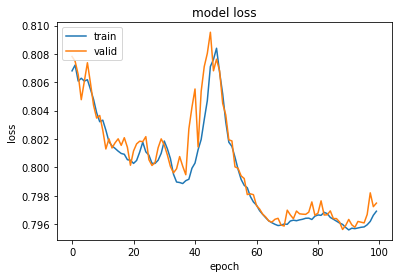

In [40]:
import matplotlib.pyplot as plt
# vẽ đồ thị cho lost
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Dự đoán khi đưa dữ liệu đầu vào và đo độ chính xác bằng Bleu Score

In [41]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

def bleu_score(pred, target):
    return sentence_bleu([word_tokenize(target)], word_tokenize(pred), weights=(1, 0, 0, 0))

In [42]:
from torchmetrics import WordErrorRate
wer = WordErrorRate() # (ref, hyp)

In [47]:
def predict(data, n_to_predict):
    """
        input: truyền vào data và số dữ liệu muốn dự đoán
        hàm này sẽ in ra câu mong muốn, câu dự đoán và bên cạnh đó còn có tính bleu score in ra màn hình
    """
    test = data[:n_to_predict]
    ds = create_tf_dataset(test, bs=n_to_predict)
    
    batch = next(iter(ds))
    # lấy phổ và text của phổ đó
    source = batch["source"]
    target = batch["target"].numpy()
    bs = tf.shape(source)[0]

    target_start_token_idx = 10
    target_end_token_idx = 11
    # dự doán dữ liệu truyền vào
    preds = model.generate(source, target_start_token_idx)
    preds = preds.numpy()

    for i in range(bs):
        target_text = "".join([idx_to_char[_] for _ in target[i, :]])
        prediction = ""
        # chuyển vector từ thành câu hoàn chỉnh
        for idx in preds[i, :]:
            prediction += idx_to_char[idx]
            if idx == target_end_token_idx:
                break

        score = bleu_score(prediction, target_text.replace('-',''))
        print(f"target:     {target_text.replace('-','')}")
        print(f"prediction: {prediction}")
        print(f"Bleu Score: {score}")
        print(f"Word Error Rate: {wer(prediction, target_text.replace('-',''))}\n")

predict(train_data, 5)

target:     <a lão già tệ lắm tôi ăn ở với lão như thế mà lão xử với tôi như thế này thì ra tôi già bằng này tuổi đầu rồi còn đánh lừa một con chó>
prediction: <a lão già tệ lắm tôi ăn ở với lão như thế mà lão xử với tôi như thế này thì ra tôi già bằng này tuổi đầu rồi còn đánh lừa một con chó>
Bleu Score: 1.0
Word Error Rate: 0.0

target:     <bao giờ có bạc trăm con mới về>
prediction: <bao giờ có bạc trăm con mới về>
Bleu Score: 1.0
Word Error Rate: 0.0

target:     <biết yêu và biết ghét nhưng đời người ta không chỉ khổ một lần mỗi lần cùng đường đất sinh nhai>
prediction: <biết yêu và biết ghét nhưng đời người ta không chỉ khổ một lần mỗi lần cùng đường đất sinh nhai>
Bleu Score: 1.0
Word Error Rate: 0.0

target:     <buồn đau ích kỷ che lấp mất tôi biết vậy>
prediction: <buồn đau ích kỷ che lấp mất tôi biết vậy>
Bleu Score: 1.0
Word Error Rate: 0.0

target:     <bán hụt tiền>
prediction: <bán hụt tiền>
Bleu Score: 1.0
Word Error Rate: 0.0



In [46]:
predict(test_data, 5)

target:     <đưa thẻ>
prediction: <tôi nhất định>
Bleu Score: 0.4
Word Error Rate: 1.5

target:     <được ạ tôi đã liệu đâu vào đấy thế nào rồi cũng xong luôn mấy hôm>
prediction: <thế nó cho bắt à mặt lão đột nhiên co dúm lại những vết nhăn xô lại với nhau>
Bleu Score: 0.14285714285714285
Word Error Rate: 1.1875

target:     <đầu tóc rũ rượi>
prediction: <quần áo xộc xệch>
Bleu Score: 0.3333333333333333
Word Error Rate: 1.0

target:     <đập nhè nhẹ vào lưng nó và dấu dí>
prediction: <lão làm bộ đây thật ra thì lão chỉ tâm ngẩm thế>
Bleu Score: 0.14285714285714285
Word Error Rate: 1.3333333730697632

target:     <đặt xe điếu cuống>
prediction: <đem thư của nó sang>
Bleu Score: 0.2857142857142857
Word Error Rate: 1.25



c:\Users\hungu\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\hungu\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\hungu\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o